In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb 
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')


In [74]:
df=pd.read_csv("/Users/dwiti/Downloads/Energy data/PJME_hourly.csv")


In [75]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [76]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [77]:
df=df.set_index('Datetime')

In [78]:
color_pal=sns.color_palette()
df.index=pd.to_datetime(df.index)

<Axes: title={'center': 'PJM Energy use in MW'}, xlabel='Datetime'>

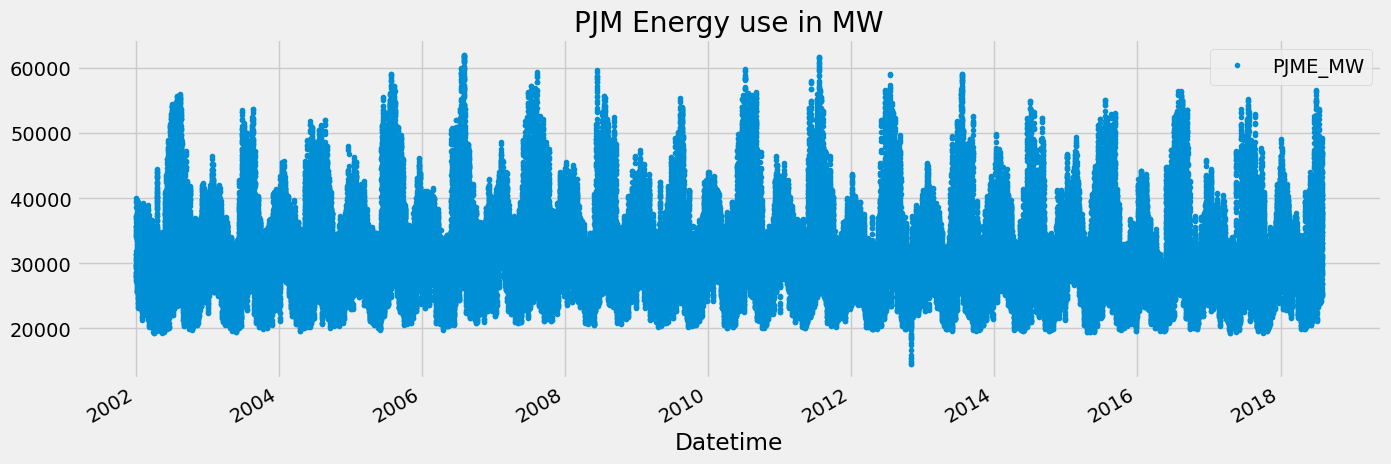

In [79]:
df.plot(style='.',figsize=(15,5),color=color_pal[0], title='PJM Energy use in MW')
        

## Train/Test Spit


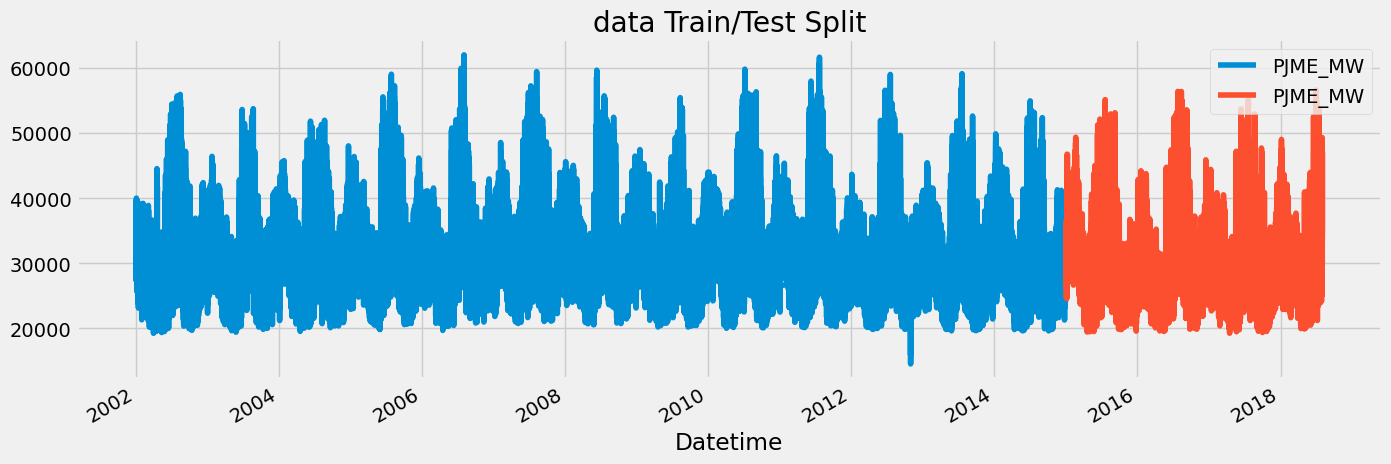

In [80]:
train=df.loc[df.index<'01-01-2015']
test=df.loc[df.index>='01-01-2015']

fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set',title='data Train/Test Split')
test.plot(ax=ax,label='Test Set')
plt.show()

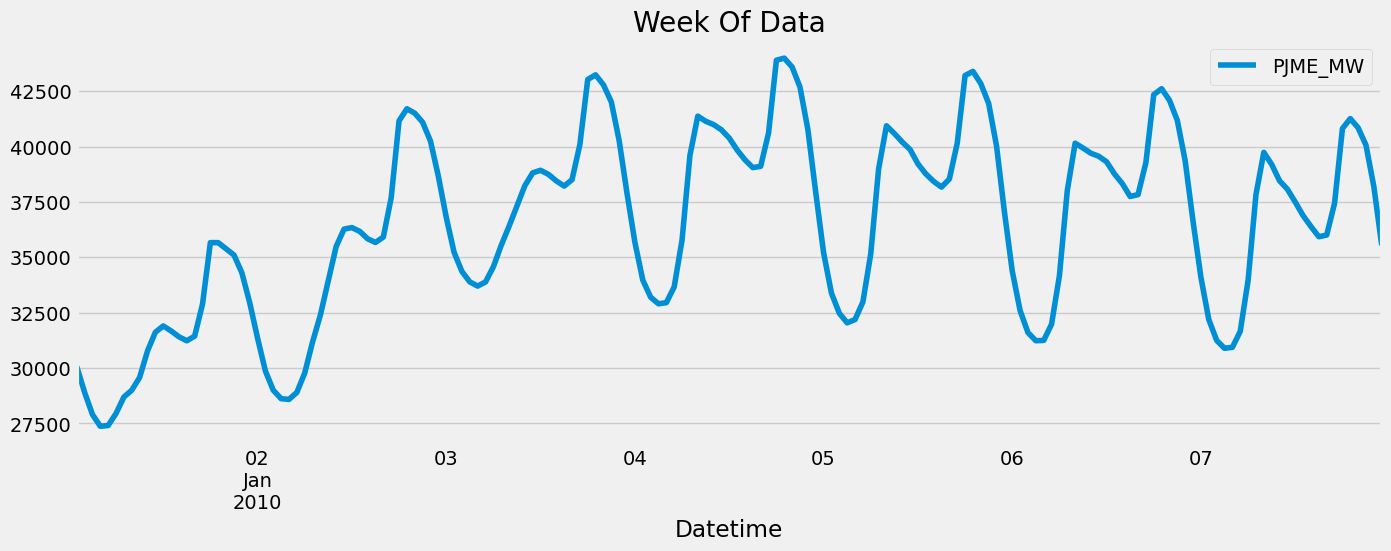

In [81]:
df = df.sort_index()
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] .plot(figsize=(15, 5), title='Week Of Data')
plt.show()



# Feature Creation



In [89]:
def create_features(df):
    """Create time series features based on time series index"""
    df = df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df
df=create_features(df)

# Visualise Feature/Target Relationship

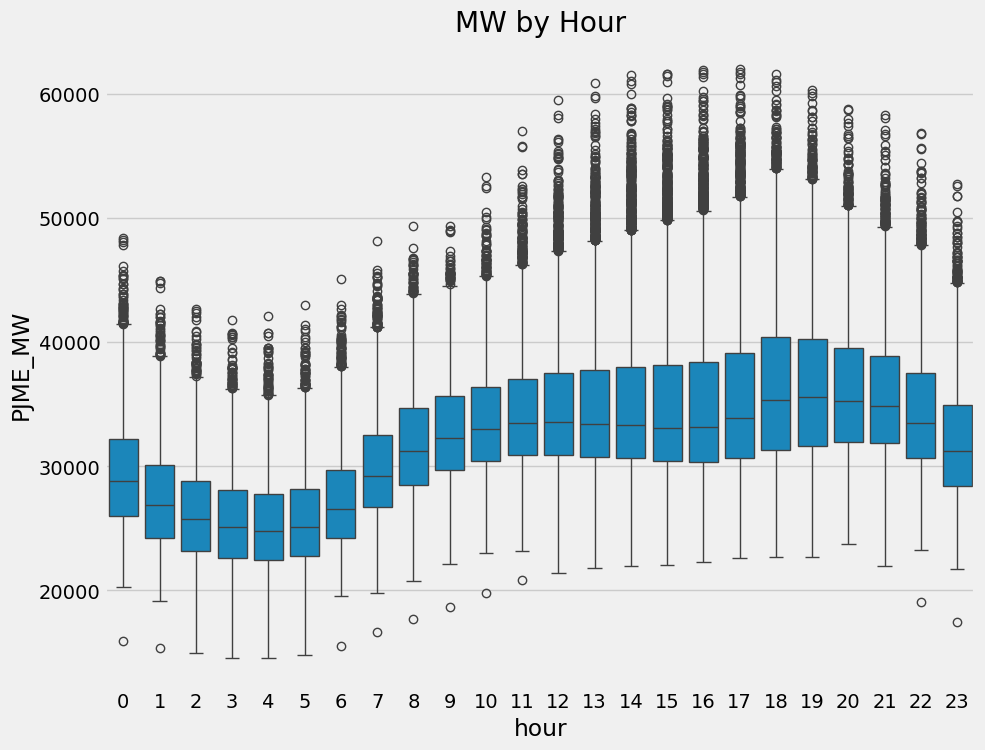

In [87]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot( data=df, x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()


C:\Users\dwiti\AppData\Local\Temp\ipykernel_22940\3362185833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='pink')


Text(0.5, 1.0, 'MW by Month')

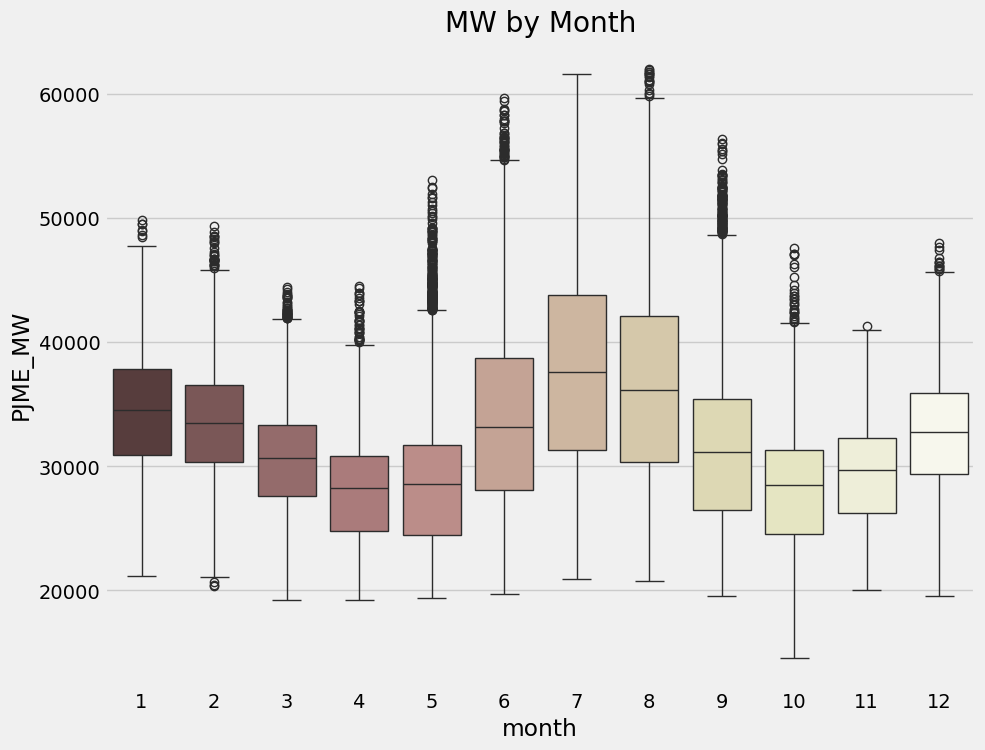

In [90]:
fig, ax =plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='pink')
ax.set_title('MW by Month')


## Create Model


In [91]:
create_features(train)
create_features(test)
FEATURES= ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET='PJME_MW'

x_train=train[FEATURES]
y_train=train[TARGET]
x_test=test[FEATURES]
y_test=test[TARGET]

In [ ]:
reg=xgb.XGBRegressor(n_estimators=1000,erly_stopping_rounds=50,learning_rate=0.01)
reg.fit(x_train,y_train,
        eval_set=[(x_train,y_train),(x_test,y_test)],
        verbose=100)


## Feature Importance 

In [92]:
feature_imp=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

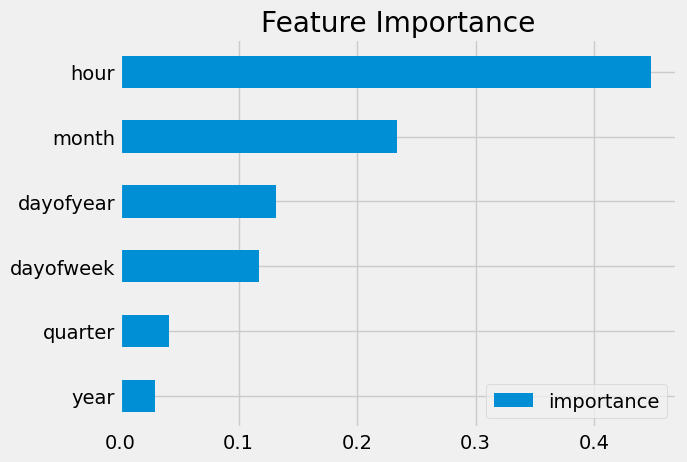

In [93]:
feature_imp.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()


## Forecast on Test


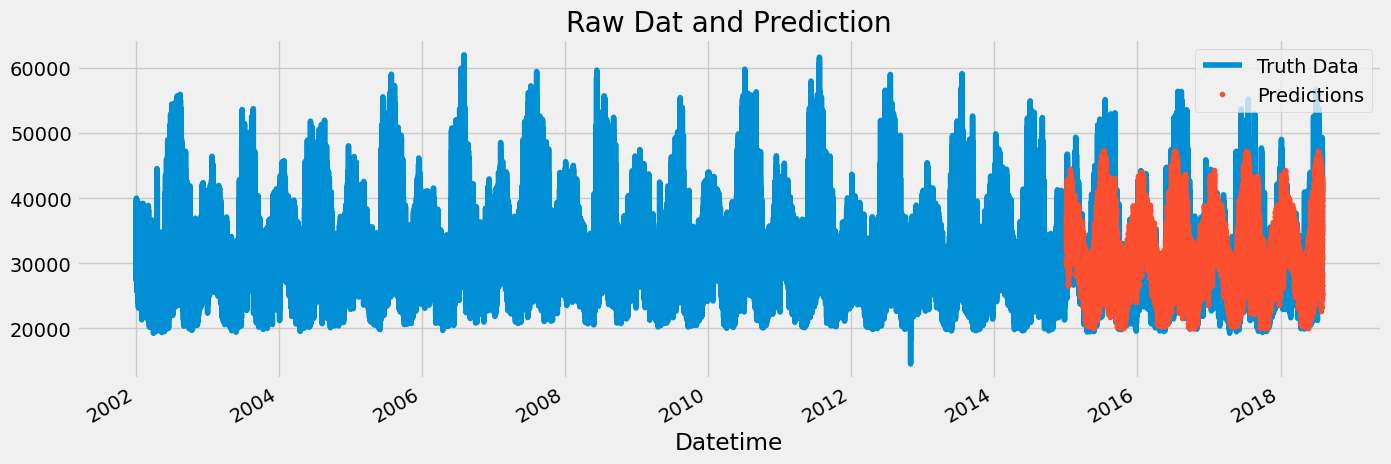

In [94]:
test['prediction']=reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

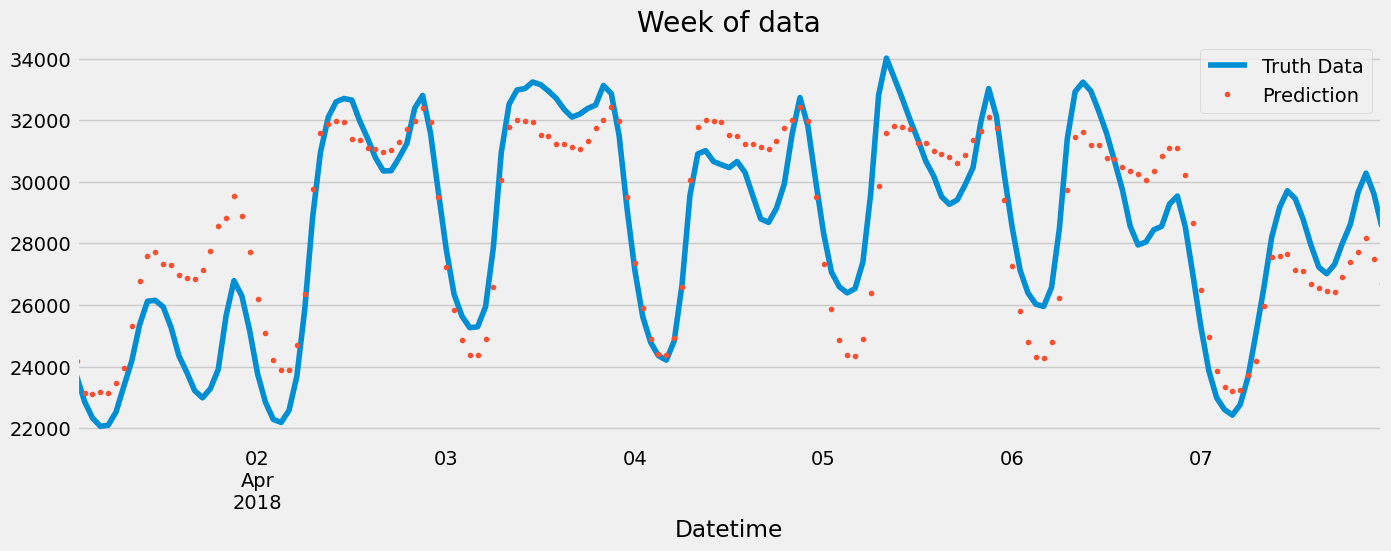

In [98]:
ax=df.loc[(df.index>'04-01-2018')& (df.index<'04-08-2018')]['PJME_MW'].plot(figsize=(15,5),title='Week of data')
df.loc[(df.index>'04-01-2018') & (df.index<'04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [101]:
score=np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on test set:{score:0.2f}')

RMSE Score on test set:3958.84


In [104]:
test['error']=np.abs(test[TARGET]-test['prediction'])

In [106]:
test['date']=test.index.date


In [108]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    16512.169678
2016-08-14    16438.347412
2016-08-12    12419.644613
2016-09-10    11107.929525
2016-09-09    10801.659017
Name: error, dtype: float64

In [110]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-10-02    336.545573
2015-10-28    340.288330
2018-05-06    386.995687
2016-05-06    399.323324
2016-10-08    415.290853
Name: error, dtype: float64